In [11]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
seed = 99
%matplotlib inline  
#os.chdir('/Users/Sriram/Desktop/DePaul/Q5/CSC529/SVM-Convex-Images')
os.chdir('C:\\Users\\SYARLAG1\\Desktop\\SVM-Convex-Images')

In [84]:
train = np.genfromtxt('convex_train.amat')
test = np.genfromtxt('convex_test.amat')

### Data Preprocessing and Exploration

(Each image is 28x28)

In [3]:
train.shape

(8000L, 785L)

In [4]:
X = train[:,:-1]
Y = train[:,-1]
X_test = test[:,:-1]
Y_test = test[:,-1]

In [5]:
X.shape

(8000L, 784L)

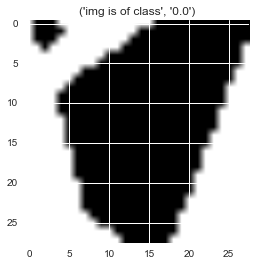

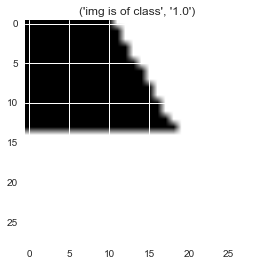

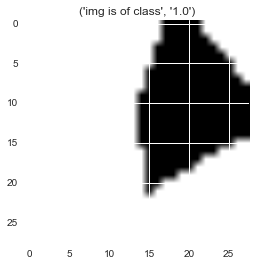

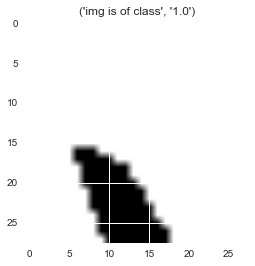

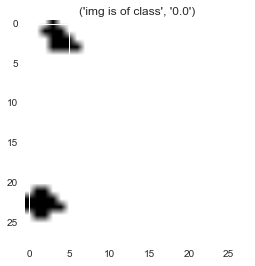

In [21]:
for i in range(5): # let us look at 5 randomly selected images
    rand_int = random.choice(range(X.shape[0]))
    img = X[rand_int]
    plt.imshow(np.reshape(img,[28,28]))
    title = 'img is of class', str(Y[rand_int])
    plt.title(title)
    plt.show()

In [100]:
# checking if there are any NAs or invalid values
NaNLst = np.sum(pd.DataFrame(X).isnull(),0) # missing value count by feature
NaNLst[NaNLst > 0]

Series([], dtype: int64)

In [102]:
X_0 = X[Y==0] # subset to non-convex
X_1 = X[Y==1] # subset to convex

In [103]:
X_0.shape

(3989L, 784L)

In [104]:
X_1.shape

(4011L, 784L)

In [108]:
X_0.sum(1)

array([ 315.,   53.,  520., ...,   79.,  252.,  169.])

In [109]:
X_1.sum(1)

array([ 364.,   99.,  697., ...,  133.,   56.,  504.])

(array([ 1165.,   491.,   350.,   344.,   296.,   298.,   277.,   259.,
          269.,   262.]),
 array([  20. ,   96.4,  172.8,  249.2,  325.6,  402. ,  478.4,  554.8,
         631.2,  707.6,  784. ]),
 <a list of 10 Patch objects>)

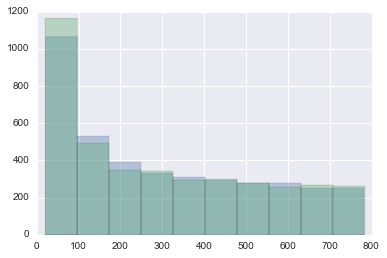

In [112]:
plt.hist(X_0.sum(1), alpha = 0.35)
plt.hist(X_1.sum(1), alpha = 0.35)

In [22]:
# visulize the datapoints using PCA
from sklearn.decomposition import PCA
pca = PCA().fit(X)
pca_X = pca.transform(X)

In [23]:
# variance explaied by first two components
sum(pca.explained_variance_ratio_[:2])

0.50931709227146771

(-0.5, 0.5)

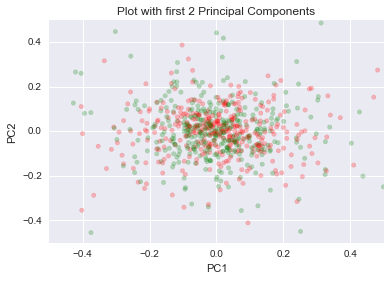

In [46]:
# plotting to see how the results look
colors = ['red' if x == 1 else 'green' for x in list(Y)]
plt.scatter(pca_X[0], pca_X[1], color=colors, alpha=0.25) # low alpha helps viz the density
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Plot with first 2 Principal Components')

# zooming in to avoid outliers
plt.xlim([-0.5,0.5])
plt.ylim([-0.5,0.5])

In [80]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
lda_X = lda.fit(X,Y).transform(X)

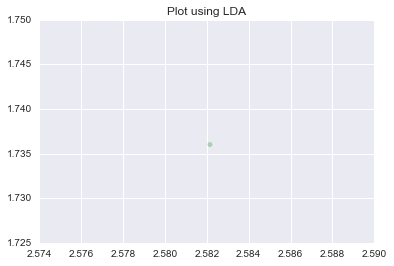

In [81]:
# plotting to see how the results look
colors = ['red' if x == 1 else 'green' for x in list(Y)]
plt.scatter(lda_X[0], lda_X[1], color=colors, alpha=0.25) # low alpha helps viz the density
plt.title('Plot using LDA')

# zooming in to avoid outliers
#plt.xlim([-0.5,0.5])
#plt.ylim([-0.5,0.5])

In [78]:
newX.shape

(8000L, 1L)

(-0.5, 0.5)

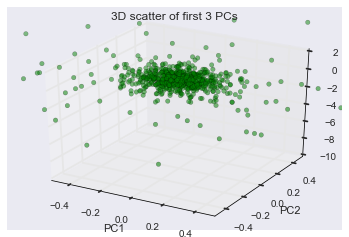

In [55]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(pca_X[0], pca_X[1], pca_X[2], c=colors)
plt.title('3D scatter of first 3 PCs')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim([-0.5,0.5])
plt.ylim([-0.5,0.5])

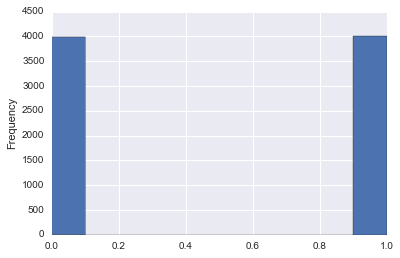

In [25]:
pd.Series(Y).plot(kind='hist') # perfectly balanced --> can use accuracy as performance metric

In [26]:
# there doesnt seem to be any discernable pattern here

### Applying Kernel SVM on the data

In [27]:
from sklearn import svm
from sklearn.cross_validation import KFold

In [30]:
# perform cross validation to determine parameters
#Function to measure the MAE based on different parameters
def calc_params(X, y, clf, param_values, param_name, K):

    # Convert input to Numpy arrays
    X = np.array(X)
    y = np.array(y)

    # initialize training and testing scores with zeros
    train_scores = np.zeros(len(param_values))
    test_scores = np.zeros(len(param_values))
    
    # iterate over the different parameter values
    for i, param_value in enumerate(param_values):
        #print(param_name, ' = ', param_value)
        
        # set classifier parameters
        clf.set_params(**{param_name:param_value})
        
        # initialize the K scores obtained for each fold
        k_train_scores = np.zeros(K)
        k_test_scores = np.zeros(K)
        
        # create KFold cross validation or stratified bootstrap validation
        cv = KFold(len(X), K, shuffle=True, random_state=99)
        
        # iterate over the K folds
        for j, (train, test) in enumerate(cv):
            # fit the classifier in the corresponding fold
            # and obtain the corresponding accuracy scores on train and test sets
            clf.fit([X[k] for k in train], y[train])
            
            k_train_scores[j] = clf.score([X[k] for k in train], y[train])
            k_test_scores[j] = clf.score([X[k] for k in test], y[test])
       
       # store the mean of the K fold scores
        train_scores[i] = np.mean(k_train_scores)
        test_scores[i] = np.mean(k_test_scores)
       
    # plot the training and testing scores in a log scale
    plt.figure()
    if type(param_values[0]) == str: # we are looking at string parameters
        sns.pointplot(param_values,train_scores, palette="Greens_d")
        sns.pointplot(param_values,test_scores, palette="Blues_d")
        plt.title('Green: Train Results, Blue: Test Results')
        plt.xlabel(param_name + " values")
        plt.ylabel("Mean cross validation accuracy value")
        plt.show()
    else:
        plt.plot(param_values, train_scores, label='Train', alpha=0.4, lw=2, c='b')
        plt.plot(param_values, test_scores, label='Test', alpha=0.4, lw=2, c='g')
        plt.legend(loc=7)
        plt.xlabel(param_name + " values")
        plt.ylabel("Mean cross validation accuracy value")
        plt.show()

    # return the training and testing scores on each parameter value
    return train_scores, test_scores

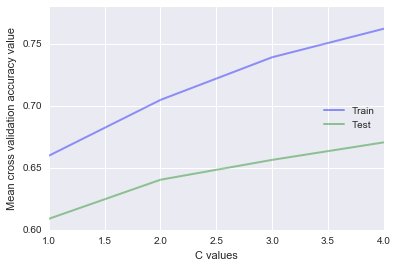

In [29]:
# 3 Fold CV
# test out diff penalities C
svm_cv = svm.SVC(random_state=seed) # initialize the regressor
Cs = list(range(1,5,1))
train_scores, test_scores = calc_params(X, Y, svm_cv, Cs, 'C', 3)

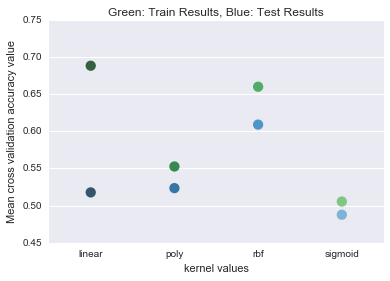

In [45]:
# test out diff penalities C
svm_cv = svm.SVC(random_state=seed) # initialize the regressor
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
train_scores, test_scores = calc_params(X, Y, svm_cv, kernels, 'kernel', 3)

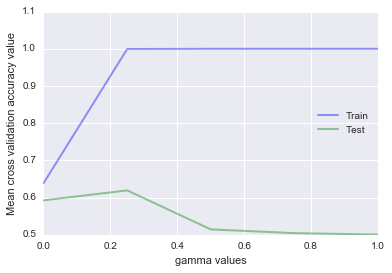

In [31]:
# since RBF clearly provides the better bais-variance trade-off
# We further investigate RBF and tune the sigma value
svm_cv = svm.SVC(random_state=seed, kernel='rbf') # initialize the regressor
gammas = np.linspace(0.001,1, num=5)
train_scores, test_scores = calc_params(X, Y, svm_cv, gammas, 'gamma', 3)

In [46]:
## Since we have a lot of features, the training process is very slow. Let us look at how it would fair after using pca to extract few features

In [94]:
# using the best model:
svm_final_clf = svm.SVC(random_state=seed, kernel='rbf', gamma = 0.25, C=5)
%time fit = svm_final_clf.fit(X,Y)

Wall time: 2min 14s


In [95]:
%time Accuracy_on_test = fit.score(X_test, Y_test) # accuracy on the test data
print 'The accuracy of SVM on the test data is ', str(Accuracy_on_test)

Wall time: 5min 56s
The accuracy of SVM on the test data is  0.64616


In [90]:
### since it is taking so long for the SVm classifier to learn from the data, we try with reduced dimensionality, using the features from PCA
## Only using the first two components 
newX = pca.transform(X)[:,:2]
newX_test = pca.transform(X_test)[:,:2]

In [91]:
%time fit_red = svm_final_clf.fit(newX,Y)

Wall time: 4.33 s


In [92]:
%time Accuracy_on_test = fit_red.score(newX_test, Y_test) # accuracy on the test data
print 'The accuracy of SVM on the test data is ', str(Accuracy_on_test)

Wall time: 8.18 s
The accuracy of SVM on the test data is  0.596


In [97]:
# performing classification using LDA to compare the performance 
lda = LinearDiscriminantAnalysis()
%time fit = lda.fit(X,Y)

Wall time: 814 ms


In [98]:
%time lda.score(X_test, Y_test)

Wall time: 227 ms


0.52092000000000005